In [24]:
import os
import glob
import pickle
import numpy as np
def parse_logfile(filename):
    logfile = open(filename, 'r')
    lines = logfile.readlines()
    logfile.close()

    iteration_data = []
    current_iteration = {}

    for line in lines:
        if line.startswith('ITERATION:'):
            if current_iteration:
                iteration_data.append(current_iteration)
                current_iteration = {}
        elif line.startswith('summary'):
            current_iteration['summary'] = line.strip()
        elif line.startswith('number of regions step'):
            current_iteration['number_of_regions_step'] = int(line.split()[-1])
        elif line.startswith('number of regions total'):
            current_iteration['number_of_regions_total'] = int(line.split()[-1])
        elif line.startswith('tstep'):
            a = line.replace(',', '')
            current_iteration['tstep'] = float(a.split()[1])
            current_iteration['t_total'] = float(a.split()[3])
        elif line.startswith('tsample'):
            a = line.replace(',', '')
            current_iteration['tsample'] = float(a.split()[1])
            current_iteration['t_visgraph'] = float(a.split()[3])
        elif line.startswith('t_mhs'):
            current_iteration['t_mhs'] = float(line.split()[1])
        elif line.startswith('t_regions'):
            current_iteration['t_regions'] = float(line.split()[1])
        elif line.startswith('coverage'):
            current_iteration['coverage'] = float(line.split()[1])
        elif '[VisSeeder] Coverage met, terminated' in line:
            current_iteration['termination'] = line.strip()

    if current_iteration:
        iteration_data.append(current_iteration)
    return iteration_data


logs_directory = 'logs'

# Get a list of all subdirectories in the logs directory
experiment_directories = [directory for directory in glob.glob(os.path.join(logs_directory, '*')) if os.path.isdir(directory)]

# Define a dictionary to store the grouped experiments
grouped_experiments = {}

# Iterate over each experiment directory
for experiment_directory in experiment_directories:
    # Parse the experiment name
    experiment_name = os.path.basename(experiment_directory)
    name_parts = experiment_name.split('_')
    
    # Extract the relevant values from the experiment name
    b = 1#int(name_parts[-5])
    N = int(name_parts[-3])
    
    # Get the last pickle file in the 'data' subdirectory
    data_directory = os.path.join(experiment_directory, 'data')
    pickle_files = glob.glob(os.path.join(data_directory, '*.pkl'))
    pkl_files = os.listdir(data_directory)
    pkl_idx = np.argsort([int(s.replace('it_', '').replace('.pkl', '')) for s in pkl_files])
    
    #pickle_files.sort()
    
    last_pickle_file = data_directory+'/'+pkl_files[pkl_idx[-1]]#pickle_files[-1]#max(pickle_files, key=os.path.getctime)
    
    # Load the last pickle file
    with open(last_pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    # Find the 'summar' subdirectory and get the path to the text file
    summar_directory = os.path.join(experiment_directory, 'summary')
    text_files = glob.glob(os.path.join(summar_directory, '*.txt'))
    last_text_file = max(text_files, key=os.path.getctime)
    

    iteration_dictionaries = parse_logfile(last_text_file)
    tsample = np.sum([i['tsample'] for i in iteration_dictionaries[1:]])
    tvis = np.sum([i['t_visgraph'] for i in iteration_dictionaries[1:]])
    tmhs = np.sum([i['t_mhs'] for i in iteration_dictionaries[1:]])
    tregions = np.sum([i['t_regions'] for i in iteration_dictionaries[1:]])
    # # Read the last line of the text file to extract coverage
    # with open(last_text_file, 'r') as file:
    #     lines = file.readlines()
    #     last_line = lines[-1].strip()
    #     coverage = float(last_line.split()[1])

    # Group experiments by 'b' value
    if b not in grouped_experiments:
        grouped_experiments[b] = {}
    
    # Group experiments by 'N' value
    if N not in grouped_experiments[b]:
        grouped_experiments[b][N] = []
    
    # Add the experiment data to the grouped experiments dictionary
    grouped_experiments[b][N].append([
            np.sum(len(g) for g in data['rb']), data['cov'] , data['ttotal'], tsample, tvis, tmhs, tregions])

# Print the grouped experiments
for b, experiments in grouped_experiments.items():
    print(f"Experiments with b = {b}:")
    for N, experiment_data in experiments.items():
        print(f"  Experiments with N = {N}:")
        for dat in experiment_data:
            print(f"    Experiment data: {dat}")

<ipython-input-24-a90786fd5239>:105: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(g) for g in data['rb']), data['cov'] , data['ttotal'], tsample, tvis, tmhs, tregions])


Experiments with b = 1:
  Experiments with N = 40:
    Experiment data: [10, 0.9116, 169.58659625053406, 22.648, 6.881, 0.136, 139.923]
    Experiment data: [6, 0.9184, 108.39339876174927, 7.45, 4.173, 0.068, 96.701]
    Experiment data: [9, 0.902, 158.07084584236145, 15.286, 4.404, 0.106, 138.27499999999998]
    Experiment data: [9, 0.9246, 162.03331542015076, 15.294, 5.59, 0.14800000000000002, 141.0]
    Experiment data: [8, 0.9074, 133.5380561351776, 7.316, 3.106, 0.06, 123.05600000000001]
  Experiments with N = 400:
    Experiment data: [10, 0.9048, 565.1213231086731, 13.568999999999999, 390.717, 3.255, 157.581]
    Experiment data: [6, 0.9168, 461.4970214366913, 14.895000000000001, 352.185, 2.9299999999999997, 91.486]
    Experiment data: [5, 0.9074, 279.491051197052, 0.624, 199.009, 1.837, 78.021]
    Experiment data: [6, 0.8914, 297.4653420448303, 0.634, 203.751, 1.955, 91.125]
    Experiment data: [7, 0.8992, 448.60080790519714, 12.654, 324.11199999999997, 2.562, 109.273]
  Exp

In [59]:
(np.array(grouped_experiments[1][1])[:, -4:]).mean(axis = 0)

array([ 97.8732,   0.7348,   0.283 , 115.0566])

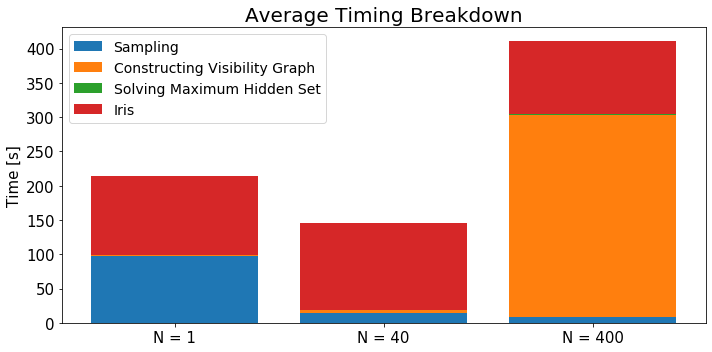

In [70]:
#timing plot 

import matplotlib.pyplot as plt
import numpy as np

# Sample data for three approaches and three phases
approaches = ['N = 1', 'N = 40', 'N = 400']
phases = ['Sampling', 'Constructing Visibility Graph', 'Solving Maximum Hidden Set', 'Iris']

approach1_times = (np.array(grouped_experiments[1][1])[:, -4:]).mean(axis = 0)  # Time contributions for Approach 1
approach2_times = (np.array(grouped_experiments[1][40])[:, -4:]).mean(axis = 0)   # Time contributions for Approach 2
approach3_times = (np.array(grouped_experiments[1][400])[:, -4:]).mean(axis = 0) # Time contributions for Approach 3

# Calculate the cumulative sum for each approach's time contributions
approach1_cumulative = np.cumsum(approach1_times)
approach2_cumulative = np.cumsum(approach2_times)
approach3_cumulative = np.cumsum(approach3_times)

time_data = np.array([approach1_times,approach2_times,approach3_times] )
time_data_cumusum  = np.array([approach1_cumulative,approach2_cumulative,approach3_cumulative] )
# Plotting the stacked bar plot
fig, ax = plt.subplots(figsize = (10,5))

ax.bar(approaches, time_data[:, 0], label=phases[0])
ax.bar(approaches, time_data[:, 1], bottom=time_data_cumusum[:, 0], label=phases[1])
ax.bar(approaches, time_data[:, 2], bottom=time_data_cumusum[:, 1], label=phases[2])
ax.bar(approaches, time_data[:, 3], bottom=time_data_cumusum[:, 2], label=phases[3])
#ax.bar(approaches, approach2_times, bottom=approach1_cumulative, label='Phase 2')
#ax.bar(approaches, approach3_times, bottom=approach2_cumulative, label='Phase 3')

# Adding labels, title, and legend
#ax.set_xlabel('Approaches',)
ax.set_ylabel('Time [s]', fontsize = 15)
ax.set_title('Average Timing Breakdown', fontsize = 20)
ax.legend(fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=15)
    
plt.tight_layout()
plt.savefig('timings_3dof.pdf')
plt.show()


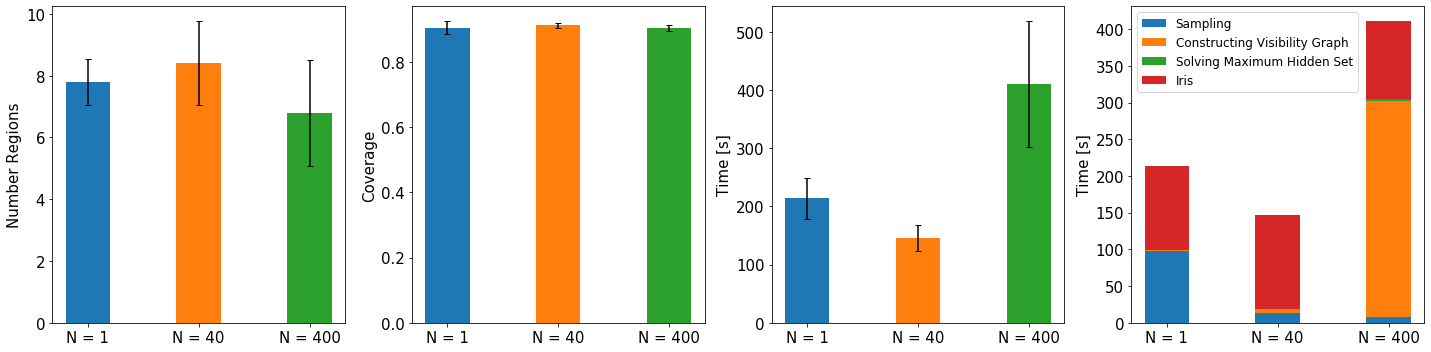

In [132]:
import matplotlib.pyplot as plt

# Sample data for three approaches and three phases
approaches = ['N = 1', 'N = 40', 'N = 400']
# phases = ['Phase 1', 'Phase 2', 'Phase 3']

# approach1_times = [10, 15, 5]  # Time contributions for Approach 1
# approach2_times = [8, 12, 6]   # Time contributions for Approach 2
# approach3_times = [12, 10, 8]  # Time contributions for Approach 3


# Plotting the bar plot
fig, axs = plt.subplots(ncols = 4, nrows =1, figsize = (20,5))
index = range(len(approaches))
bar_width = 0.4

ax = axs[0]
m = []
min_max = []
std = []
for n in [1,40,400]:
    exp_arr = np.array(grouped_experiments[1][n])
    m.append((exp_arr[:, 0]).mean(axis = 0))
    min_max.append([(exp_arr[:, 0]).min(), (exp_arr[:, 0]).max()]) 
    std.append((exp_arr[:, 0]).std(axis = 0))
for i in range(3):
    ax.bar(index[i],m[i],bar_width)
    # Plot the error bars
bounds = np.array(min_max)-np.array(m).reshape(-1,1)
#ax.errorbar(index, m, yerr=[-bounds[:,0], bounds[:,1]], fmt='none', ecolor='k', capsize=3)
ax.errorbar(index, m, yerr=std, fmt='none', ecolor='k', capsize=3)

# Adding labels, titles, and legend
ax.set_ylabel('Number Regions', fontsize = 15)
ax.set_xticks([i for i in index])
ax.set_xticklabels(approaches)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = axs[1]
m = []
min_max = []
std = []
for n in [1,40,400]:
    exp_arr = np.array(grouped_experiments[1][n])
    m.append((exp_arr[:, 1]).mean(axis = 0))
    min_max.append([(exp_arr[:, 1]).min(), (exp_arr[:, 1]).max()]) 
    std.append((exp_arr[:, 1]).std(axis = 0))
for i in range(3):
    ax.bar(index[i],m[i],bar_width)
    # Plot the error bars
bounds = np.array(min_max)-np.array(m).reshape(-1,1)
#ax.errorbar(index, m, yerr=[-bounds[:,0], bounds[:,1]], fmt='none', ecolor='k', capsize=3)
ax.errorbar(index, m, yerr=std, fmt='none', ecolor='k', capsize=3)

# Adding labels, titles, and legend
ax.set_ylabel('Coverage', fontsize = 15)
ax.set_xticks([i for i in index])
ax.set_xticklabels(approaches)
ax.tick_params(axis='both', which='major', labelsize=15)
ax = axs[2]
m = []
min_max = []
std = []
for n in [1,40,400]:
    exp_arr = np.array(grouped_experiments[1][n])
    m.append((exp_arr[:, 2]).mean(axis = 0))
    min_max.append([(exp_arr[:, 2]).min(), (exp_arr[:, 2]).max()]) 
    std.append((exp_arr[:, 2]).std(axis = 0))
for i in range(3):
    ax.bar(index[i],m[i],bar_width)
    # Plot the error bars
bounds = np.array(min_max)-np.array(m).reshape(-1,1)
#ax.errorbar(index, m, yerr=[-bounds[:,0], bounds[:,1]], fmt='none', ecolor='k', capsize=3)
ax.errorbar(index, m, yerr=std, fmt='none', ecolor='k', capsize=3)

# Adding labels, titles, and legend
ax.set_ylabel('Time [s]', fontsize = 15)
ax.set_xticks([i for i in index])
ax.set_xticklabels(approaches)
ax.tick_params(axis='both', which='major', labelsize=15)
# # Adding total time values above each bar
# for i, v in enumerate(total_times):
#     ax.text(i, v + 0.5, str(v), ha='center')
ax = axs[3]
#approaches = ['N = 1', 'N = 40', 'N = 400']
phases = ['Sampling', 'Constructing Visibility Graph', 'Solving Maximum Hidden Set', 'Iris']

approach1_times = (np.array(grouped_experiments[1][1])[:, -4:]).mean(axis = 0)  # Time contributions for Approach 1
approach2_times = (np.array(grouped_experiments[1][40])[:, -4:]).mean(axis = 0)   # Time contributions for Approach 2
approach3_times = (np.array(grouped_experiments[1][400])[:, -4:]).mean(axis = 0) # Time contributions for Approach 3

# Calculate the cumulative sum for each approach's time contributions
approach1_cumulative = np.cumsum(approach1_times)
approach2_cumulative = np.cumsum(approach2_times)
approach3_cumulative = np.cumsum(approach3_times)

time_data = np.array([approach1_times,approach2_times,approach3_times] )
time_data_cumusum  = np.array([approach1_cumulative,approach2_cumulative,approach3_cumulative] )
# Plotting the stacked bar plot

ax.bar(approaches, time_data[:, 0],bar_width, label=phases[0])
ax.bar(approaches, time_data[:, 1],bar_width, bottom=time_data_cumusum[:, 0], label=phases[1])
ax.bar(approaches, time_data[:, 2],bar_width, bottom=time_data_cumusum[:, 1], label=phases[2])
ax.bar(approaches, time_data[:, 3],bar_width, bottom=time_data_cumusum[:, 2], label=phases[3])
#ax.bar(approaches, approach2_times, bottom=approach1_cumulative, label='Phase 2')
#ax.bar(approaches, approach3_times, bottom=approach2_cumulative, label='Phase 3')

# Adding labels, title, and legend
#ax.set_xlabel('Approaches',)
ax.set_ylabel('Time [s]', fontsize = 15)
#ax.set_title('Average Timing Breakdown', fontsize = 20)
ax.legend(fontsize = 12,loc='upper left' )
ax.tick_params(axis='both', which='major', labelsize=15)



plt.tight_layout()
plt.savefig('3dof_comparison.pdf')
plt.show()

In [110]:
m

[7.8, 8.4, 6.8]

In [109]:
[bounds[:,0], bounds[:,1]]

[array([-0.8, -2.4, -1.8]), array([1.2, 1.6, 3.2])]

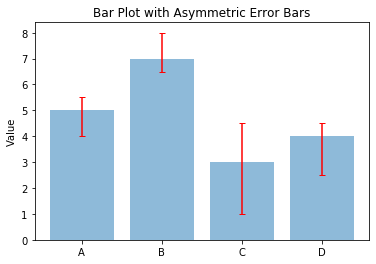

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
x = np.arange(4)
y = [5, 7, 3, 4]
y_err_lower = [1, 0.5, 2, 1.5]  # Lower error values
y_err_upper = [0.5, 1, 1.5, 0.5]  # Upper error values

# Create the plot
fig, ax = plt.subplots()

# Plot the bars
ax.bar(x, y, align='center', alpha=0.5)

# Plot the error bars
ax.errorbar(x, y, yerr=[y_err_lower, y_err_upper], fmt='none', ecolor='r', capsize=3)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(['A', 'B', 'C', 'D'])
ax.set_ylabel('Value')
ax.set_title('Bar Plot with Asymmetric Error Bars')

# Display the plot
plt.show()

In [18]:
filename = 'logs/3DOf_pinball_20230626230047_1_1_0.050_0.100/summary/summary_3DOf_pinball_20230626230047_1_1_0.050_0.100.txt'

logfile = open(filename, 'r')
lines = logfile.readlines()
logfile.close()

iteration_data = []
current_iteration = {}

for line in lines:
    if line.startswith('ITERATION:'):
        if current_iteration:
            iteration_data.append(current_iteration)
            current_iteration = {}
    elif line.startswith('summary'):
        current_iteration['summary'] = line.strip()
    elif line.startswith('number of regions step'):
        current_iteration['number_of_regions_step'] = int(line.split()[-1])
    elif line.startswith('number of regions total'):
        current_iteration['number_of_regions_total'] = int(line.split()[-1])
    elif line.startswith('tstep'):
        a = line.replace(',', '')
        current_iteration['tstep'] = float(a.split()[1])
        current_iteration['t_total'] = float(a.split()[3])
    elif line.startswith('tsample'):
        a = line.replace(',', '')
        current_iteration['tsample'] = float(a.split()[1])
        current_iteration['t_visgraph'] = float(a.split()[3])
    elif line.startswith('t_mhs'):
        current_iteration['t_mhs'] = float(line.split()[1])
    elif line.startswith('t_regions'):
        current_iteration['t_regions'] = float(line.split()[1])
    elif line.startswith('coverage'):
        current_iteration['coverage'] = float(line.split()[1])
    elif '[VisSeeder] Coverage met, terminated' in line:
        current_iteration['termination'] = line.strip()

if current_iteration:
    iteration_data.append(current_iteration)


In [23]:

iteration_data[-1]

{'number_of_regions_step': 1,
 'number_of_regions_total': 7,
 'tstep': 27.599,
 't_total': 206.908,
 'tsample': 7.218,
 't_visgraph': 0.07,
 't_mhs': 0.021,
 't_regions': 20.29,
 'coverage': 0.9162,
 'termination': '[03:04:20] [VisSeeder] Coverage met, terminated on Iris step'}

In [10]:
data.keys()

dict_keys(['vg', 'vad', 'sp', 'ra', 'rb', 'cov', 'tstep', 'tsample', 'ttotal'])

In [3]:
box_counts = [1]
# minimum_covers = [(b+1)*2 for b in box_counts]
labels = ["N=1", "N=40", "N=400"]
fields = ['Number of Regions', 'Coverage', 'Time']
N_vals = [1,40,400]

data_1_mean = []
data_40_mean = []
data_400_mean = []
dm = [data_1_mean, data_40_mean, data_400_mean]

data_1_std = []
data_40_std = []
data_400_std = []
ds = [data_1_std, data_40_std, data_400_std]


for b in box_counts:
    exps = grouped_experiments[b]
    for N_exp in N_vals:
        runs = exps[N_exp]
        run_mean = np.mean(np.array(runs), axis = 0)
        run_std = np.std(np.array(runs), axis = 0)
        dm[N_vals.index(N_exp)].append(run_mean.tolist())
        ds[N_vals.index(N_exp)].append(run_std.tolist())

In [4]:
dm

[[[7.8, 0.9046799999999999, 213.94761819839476]],
 [[8.4, 0.9128000000000001, 146.32444248199462]],
 [[6.8, 0.9039200000000001, 410.43510913848877]]]

In [ ]:
import matplotlib as plt
fig, ax= plt.subfigures



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
categories = labels
values1 = number_regions
values2 = vs_number_regions

# Set the position of the bars on the x-axis
ind = np.arange(len(categories))

# Set the width of the bars
width = 0.35

# Create the figure and axes
fig, axs = plt.subplots(nrows =1, ncols = 3, figsize = (15, 5))

ax = axs[0]
# Create the first set of bars
rects1 = ax.bar(ind - width/2, values1, width, label='CCV_CGSH')

# Create the second set of bars
rects2 = ax.bar(ind + width/2, values2, width, label='VisSeeding')

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)
ax.set_yscale('log')
# Add labels, title, and legend
ax.set_ylabel('Number of Regions')
ax.set_title('')
ax.legend()

values1 = timing_values
values2 = vs_timings
ax = axs[1]
# Create the first set of bars
rects1 = ax.bar(ind - width/2, values1, width, label='CCV_CGSH')

# Create the second set of bars
rects2 = ax.bar(ind + width/2, values2, width, label='VisSeeding')

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)
ax.set_yscale('log')
# Add labels, title, and legend
ax.set_ylabel('Time [s]')
ax.set_title('')
ax.legend()

values1 = [1]*16
values2 = coverage
ax = axs[2]
# Create the first set of bars
rects1 = ax.bar(ind - width/2, values1, width, label='CCV_CGSH')

# Create the second set of bars
rects2 = ax.bar(ind + width/2, values2, width, label='VisSeeding')

# Set custom tick labels
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation = 80)
ax.set_ylim([0,1.2])
# Add labels, title, and legend
ax.set_ylabel(' Coverage')
ax.set_title('')
ax.legend()
# Display the plot
plt.tight_layout()
plt.savefig('comparison.pdf')